# Create Dataset Splits for Training, Testing, and Drift Simulation

This notebook splits the CelebA dataset into four data splits:
- `historical_train`: Data used to train the classifier
- `historical_test`: Data used to test the classifier
- `datastream_no_drift`: Data used to simulate non-drifted data (with the same distribution as train and test)
- `datastream_drift`: Data used to simulate drift


In [1]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

/opt/conda/envs/nesy-concept-drift-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import os

## Load Dataset

In [3]:
from datasets import get_dataset_config_names

print(get_dataset_config_names("flwrlabs/celeba"))

['img_align+identity+attr']


In [4]:
ds = load_dataset("flwrlabs/celeba")

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 162770
    })
    valid: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'H

## Visualize Dataset Attribtues

In [6]:
def compute_sorted_counts(ds, split):
    df = ds[split].to_pandas()
    attribute_columns = [attr for attr in ds[split].features if attr not in ['image', 'celeb_id', 'image_id', 'is_drift' ]]

    male_df = df[df['Male'] == 1]
    female_df = df[df['Male'] == 0]

    male_counts = male_df[attribute_columns].sum().astype(int)
    female_counts = female_df[attribute_columns].sum().astype(int)

    diff = (male_counts - female_counts).abs()

    counts_df = pd.DataFrame({
        'Attribute': attribute_columns,
        'Male': male_counts,
        'Female': female_counts,
        'AbsGap': diff
    }).sort_values(by='AbsGap', ascending=False)

    return counts_df

# Bar plot sorted by absolute gender gap
def plot_sorted_counts(ds, split):
    counts_df = compute_sorted_counts(ds, split)
    counts_df.set_index("Attribute", inplace=True)

    ax = counts_df[['Male', 'Female']].plot(
        kind='bar', figsize=(16, 6),
        title=f"Attributes Sorted by Gender Gap – '{split}' Split"
    )
    ax.set_ylabel("Count of 'True' Values")
    ax.set_xlabel("Attributes (sorted by |Male - Female|)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Compute True counts per gender
def compute_counts(ds, split):
    df = ds[split].to_pandas()
    attribute_columns = [attr for attr in ds[split].features if attr not in ['image', 'celeb_id',  'image_id', 'is_drift']]

    male_df = df[df['Male'] == 1]
    female_df = df[df['Male'] == 0]

    male_counts = male_df[attribute_columns].sum().astype(int)
    female_counts = female_df[attribute_columns].sum().astype(int)

    counts_df = pd.DataFrame({
        'Attribute': attribute_columns,
        'Male': male_counts,
        'Female': female_counts
    })

    return counts_df

# Bar plot of True counts per gender
def plot_counts(ds, split):
    counts_df = compute_counts(ds, split)
    counts_df.set_index("Attribute", inplace=True)
    counts_df.sort_index(inplace=True)

    ax = counts_df.plot(
        kind='bar', figsize=(16, 6),
        title=f"Attribute True Counts in '{split}' Split"
    )
    ax.set_ylabel("Number of Samples")
    ax.set_xlabel("Attributes")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

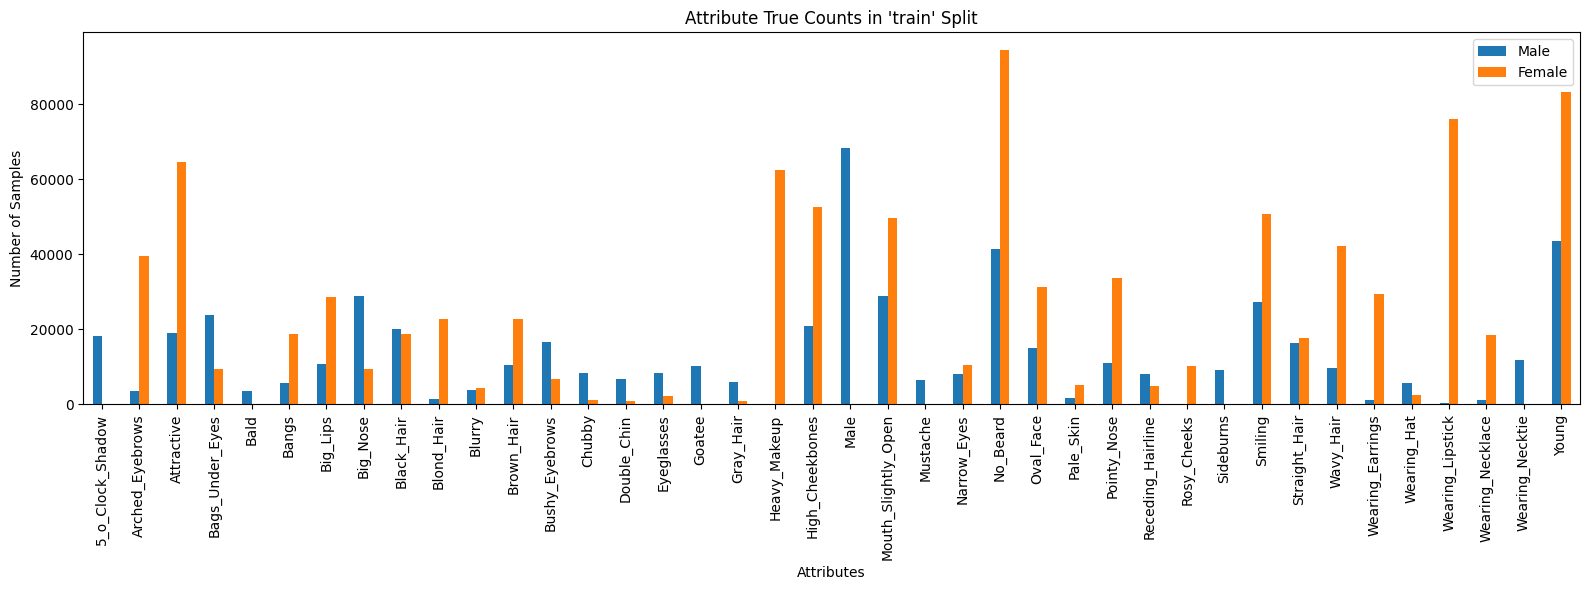

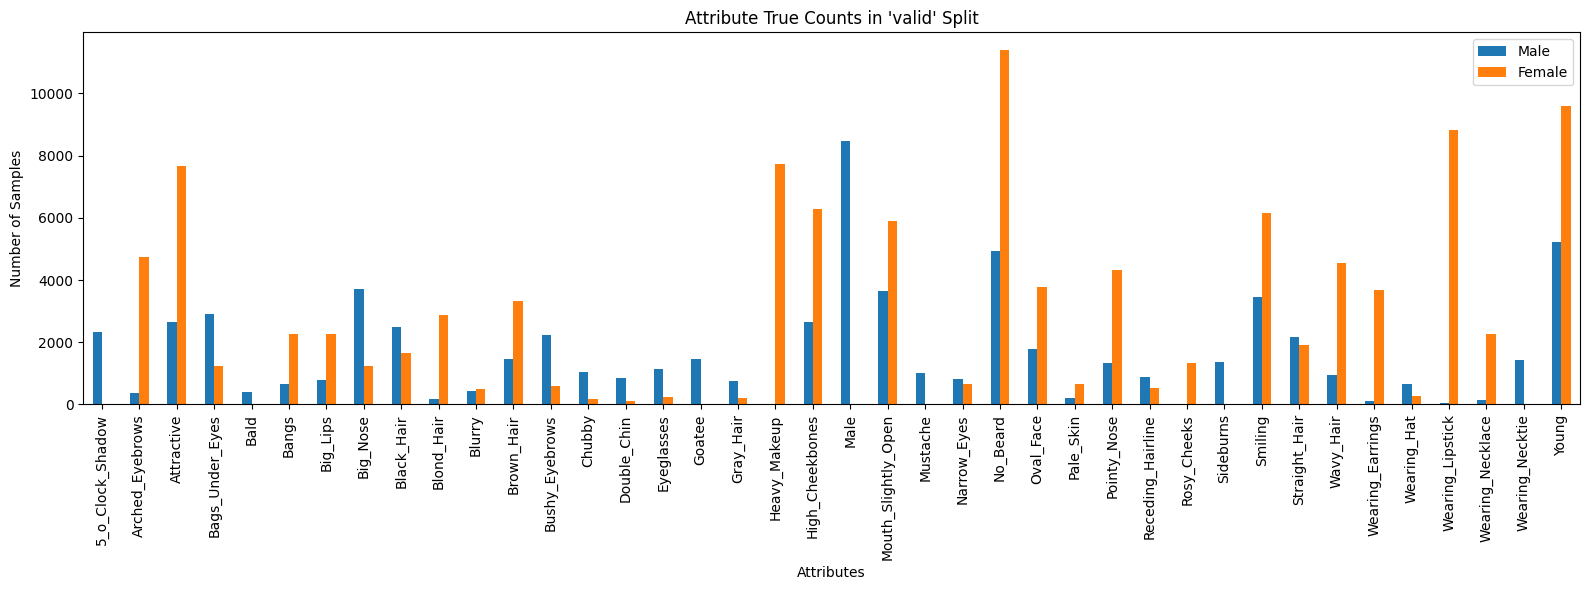

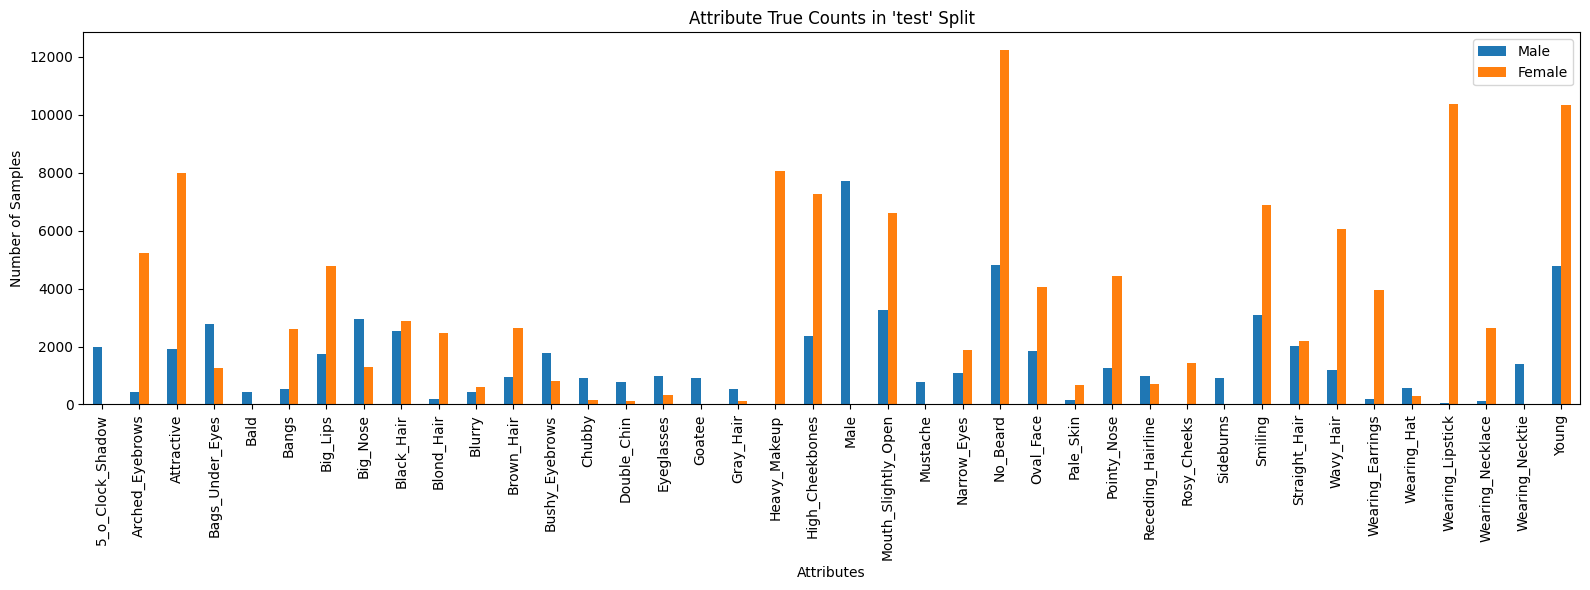

In [7]:
for split in ['train', 'valid', 'test']:
    plot_counts(ds, split)

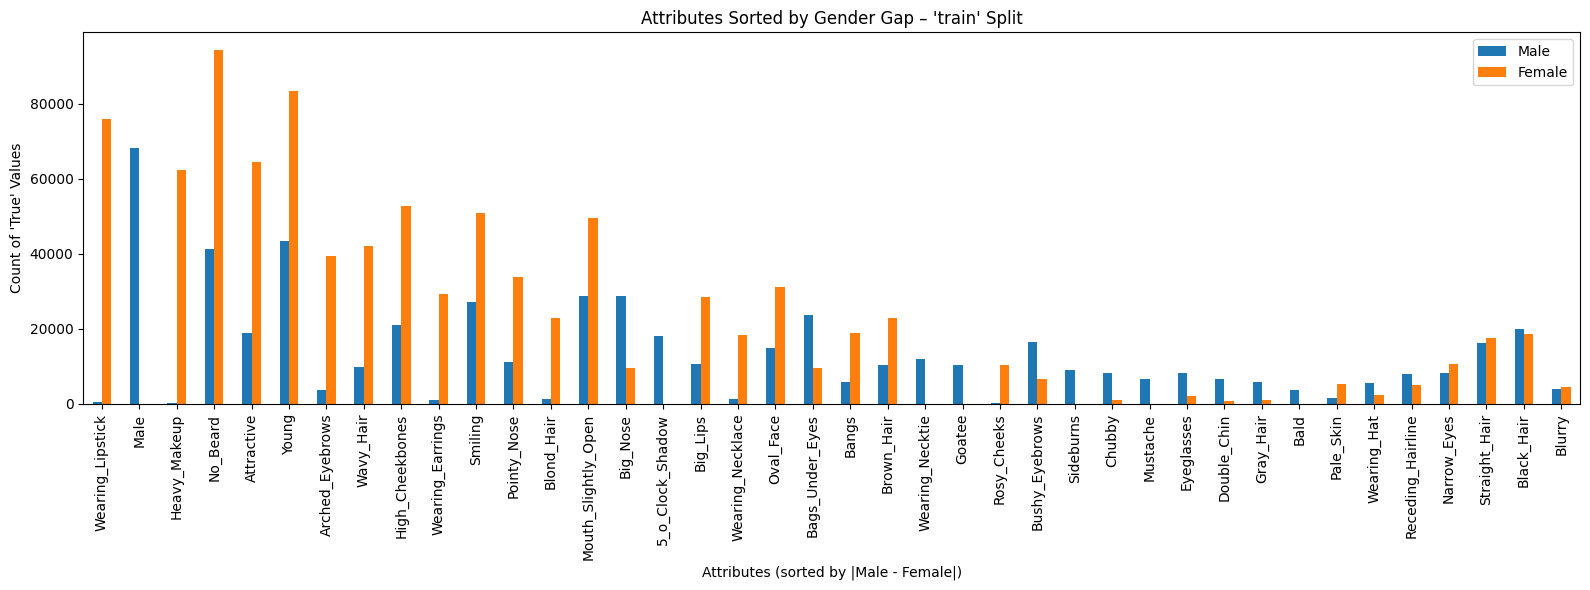

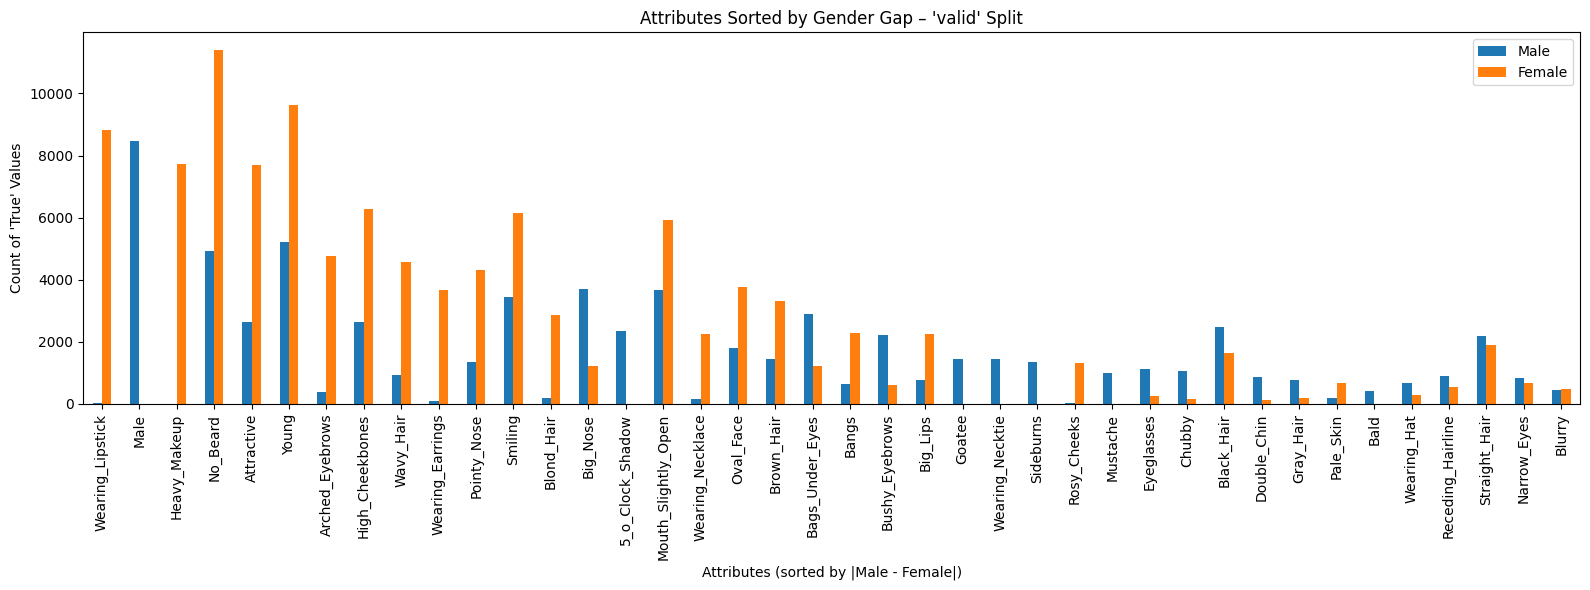

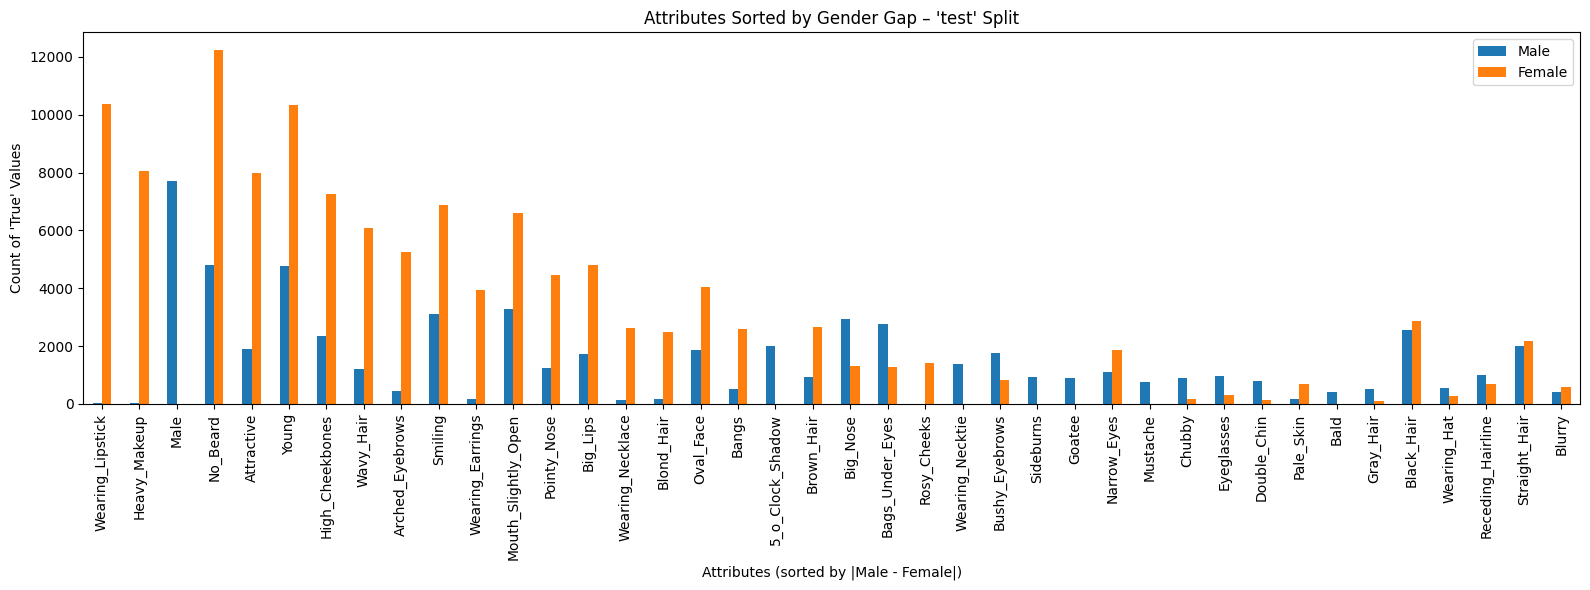

In [8]:
for split in ['train', 'valid', 'test']:
    plot_sorted_counts(ds, split)

In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 162770
    })
    valid: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'H

## Split Dataset

### Select Genders and Attributes for Drift Simulation

- `drift_genders`: A list of genders to simulate drift on — use `1` for male, `0` for female. Example: `[1]` for males only, `[0, 1]` for both.
- `drift_attributes`: A list of `(attribute, value)` pairs that define the drift condition. 
  - Each pair specifies an attribute and the value to match for drift.
  - Example: `[("Wearing_Earrings", 1), ("Wearing_Earrings", 0)]` simulates drift on individuals who are smiling or not wearing a hat.


In [10]:
# Parameters
drift_genders = [1]  # e.g., [1] = Male, [0] = Female, [0, 1] = Both
drift_attributes = [("Wearing_Earrings", 1)]  # list of (attribute, value) pairs

In [11]:
# Function to extract drift samples and remove them from a dataset
def split_drift(dataset, drift_genders, drift_attributes):
    def is_drift(example):
        gender_match = example["Male"] in drift_genders
        attribute_match = any(example[attr] == val for attr, val in drift_attributes)
        return gender_match and attribute_match

    def is_not_drift(example):
        return not is_drift(example)

    drift_subset = dataset.filter(is_drift)
    remaining_subset = dataset.filter(is_not_drift)
    return remaining_subset, drift_subset

In [12]:
# Split each part
train_clean, train_drift = split_drift(ds["train"], drift_genders, drift_attributes)
valid_clean, valid_drift = split_drift(ds["valid"], drift_genders, drift_attributes)
test_clean, test_drift = split_drift(ds["test"], drift_genders, drift_attributes)

In [13]:
drift_split = concatenate_datasets([train_drift, valid_drift, test_drift])

In [14]:
# Function to add columns and reorder
def add_columns_and_reorder(dataset, start_id, drift_value):
    # Add 'is_drift' column
    dataset = dataset.add_column("is_drift", [drift_value] * len(dataset))
    # Add 'image_id' column starting from start_id for this dataset
    ids = list(range(start_id, start_id + len(dataset)))
    dataset = dataset.add_column("image_id", ids)
    # Reorder columns to put 'image_id' and 'is_drift' first
    cols = ["image_id", "is_drift"] + [col for col in dataset.column_names if col not in ["image_id", "is_drift"]]
    dataset = dataset.select_columns(cols)
    return dataset, start_id + len(dataset)

In [15]:


# Start ID counter at 0
current_id = 0

# Add columns and reorder for each dataset
train_clean, current_id = add_columns_and_reorder(train_clean, current_id, 0)
test_clean, current_id = add_columns_and_reorder(test_clean, current_id, 0)
valid_clean, current_id = add_columns_and_reorder(valid_clean, current_id, 0)
drift_split, current_id = add_columns_and_reorder(drift_split, current_id, 1)

# Now each dataset has image_id and is_drift columns at the beginning

# Optionally rebuild DatasetDict if you want
new_ds = DatasetDict({
    "historical_train": train_clean,
    "historical_test": test_clean,
    "datastream_no_drift": valid_clean,
    "datastream_drift": drift_split
})


In [16]:
new_ds

DatasetDict({
    historical_train: Dataset({
        features: ['image_id', 'is_drift', 'image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 161711
    })
    historical_test: Dataset({
        features: ['image_id', 'is_drift', 'image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebro

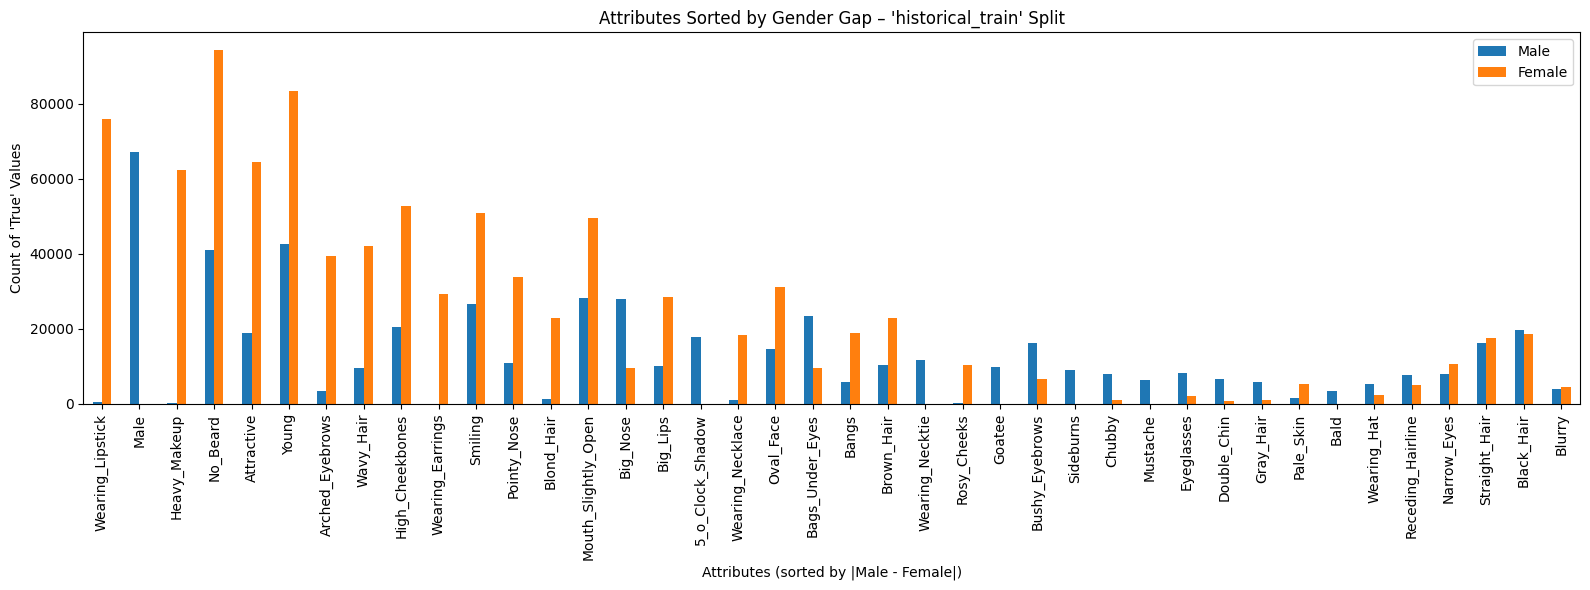

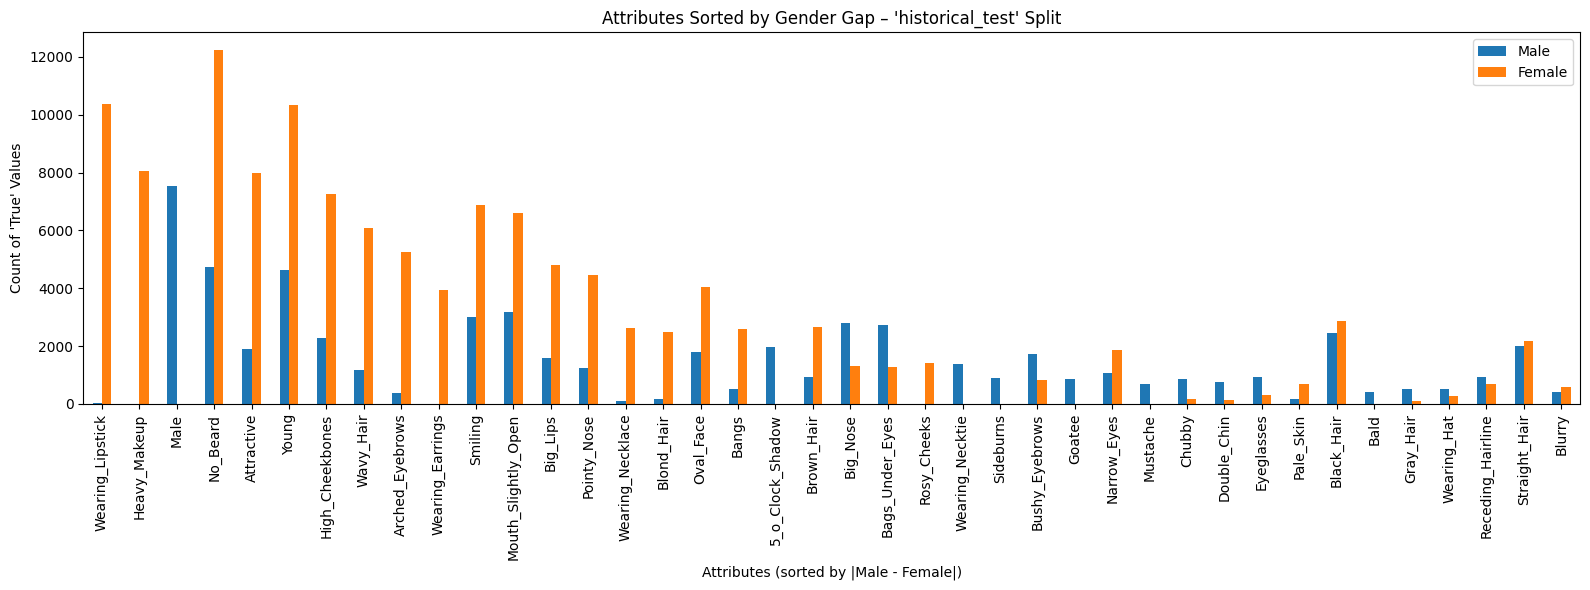

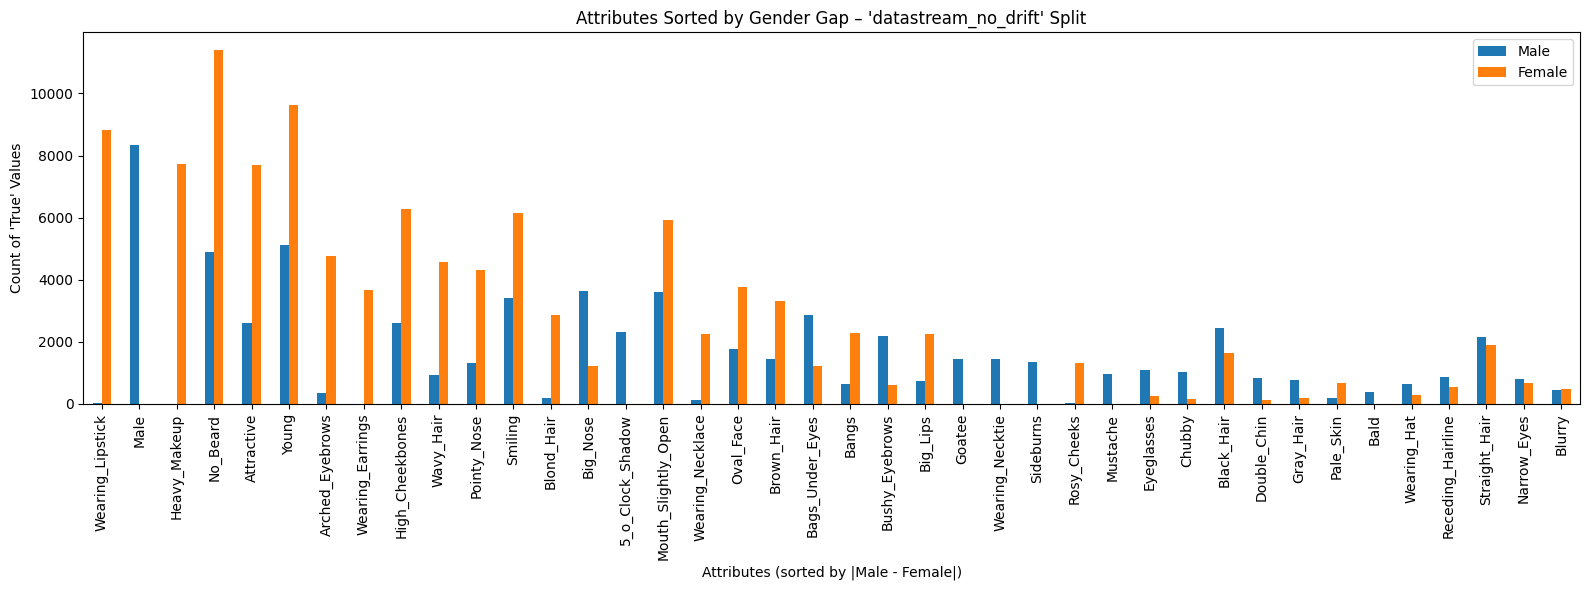

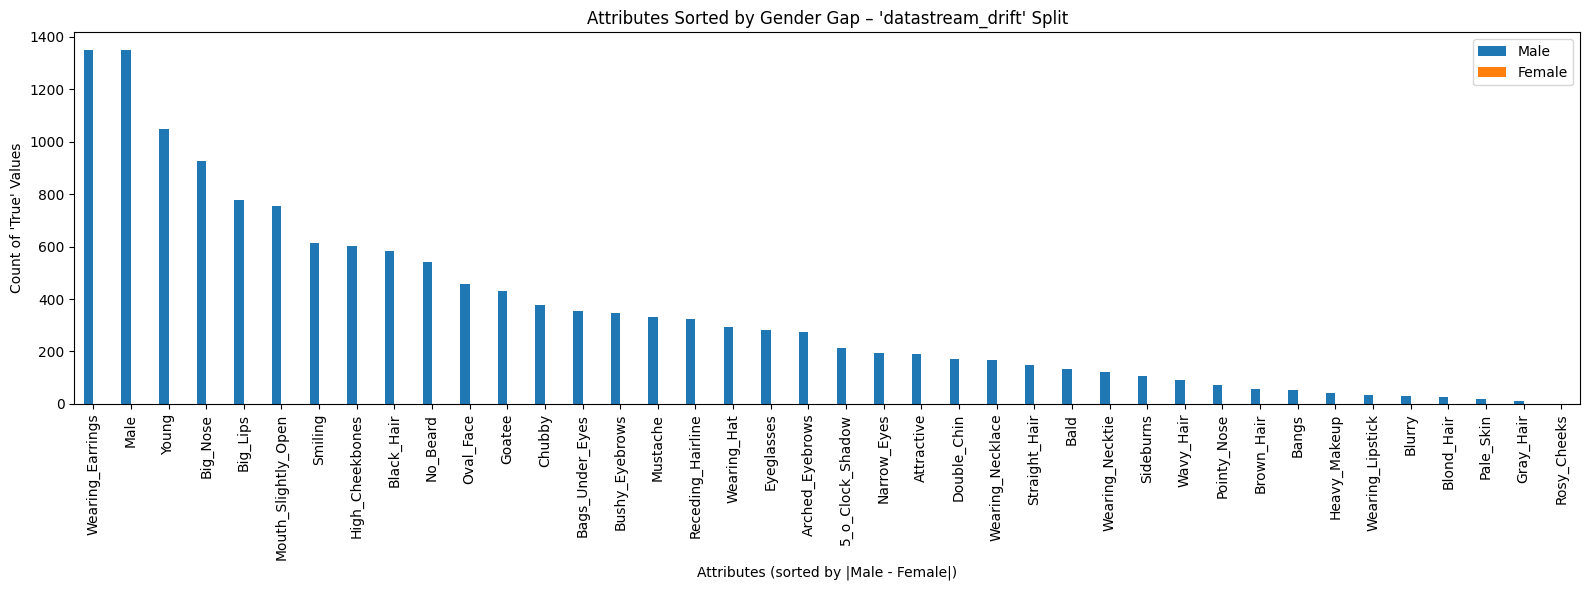

In [24]:
for split in ['historical_train', 'historical_test', 'datastream_no_drift', 'datastream_drift']:
    plot_sorted_counts(new_ds, split)

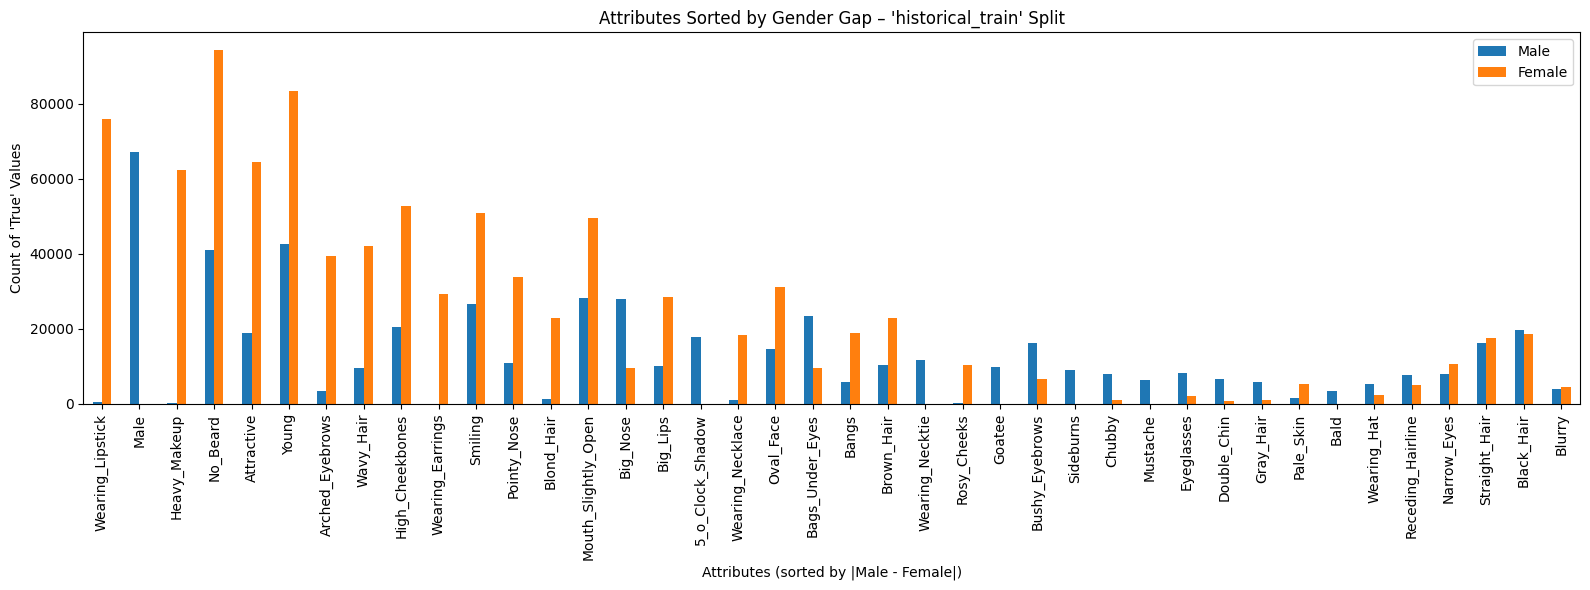

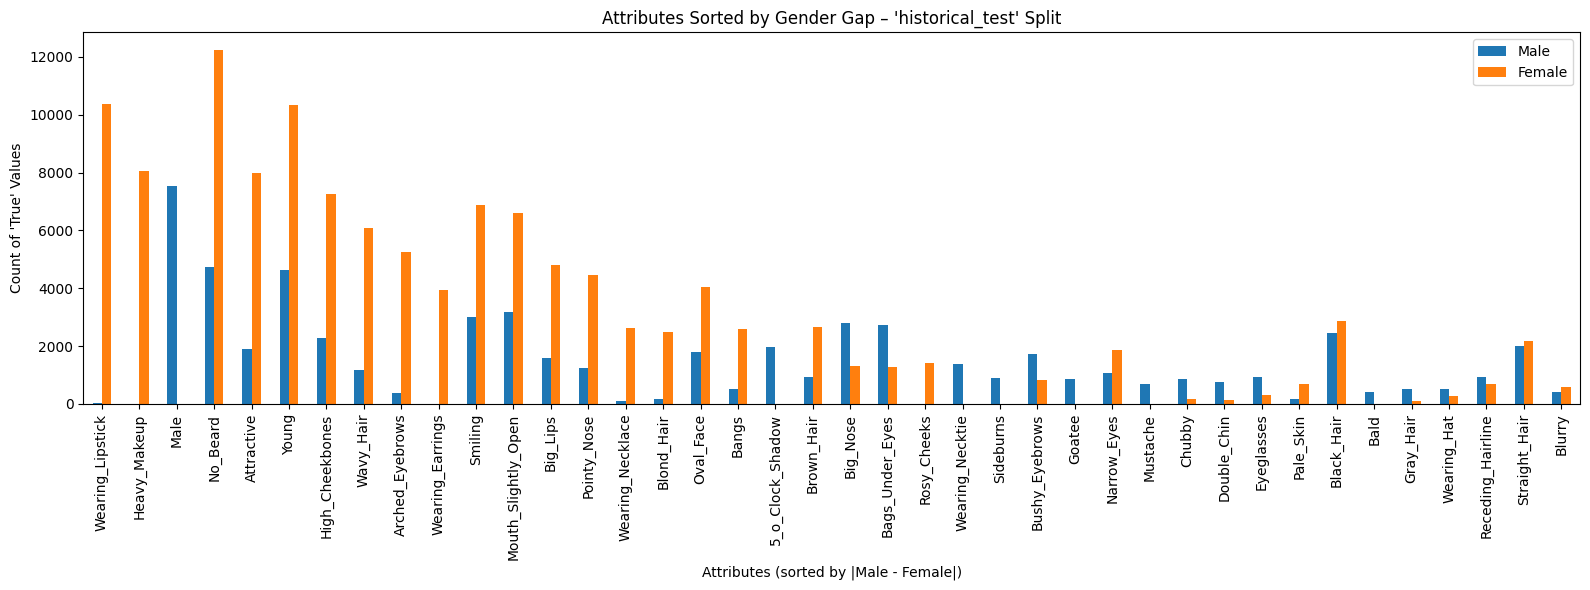

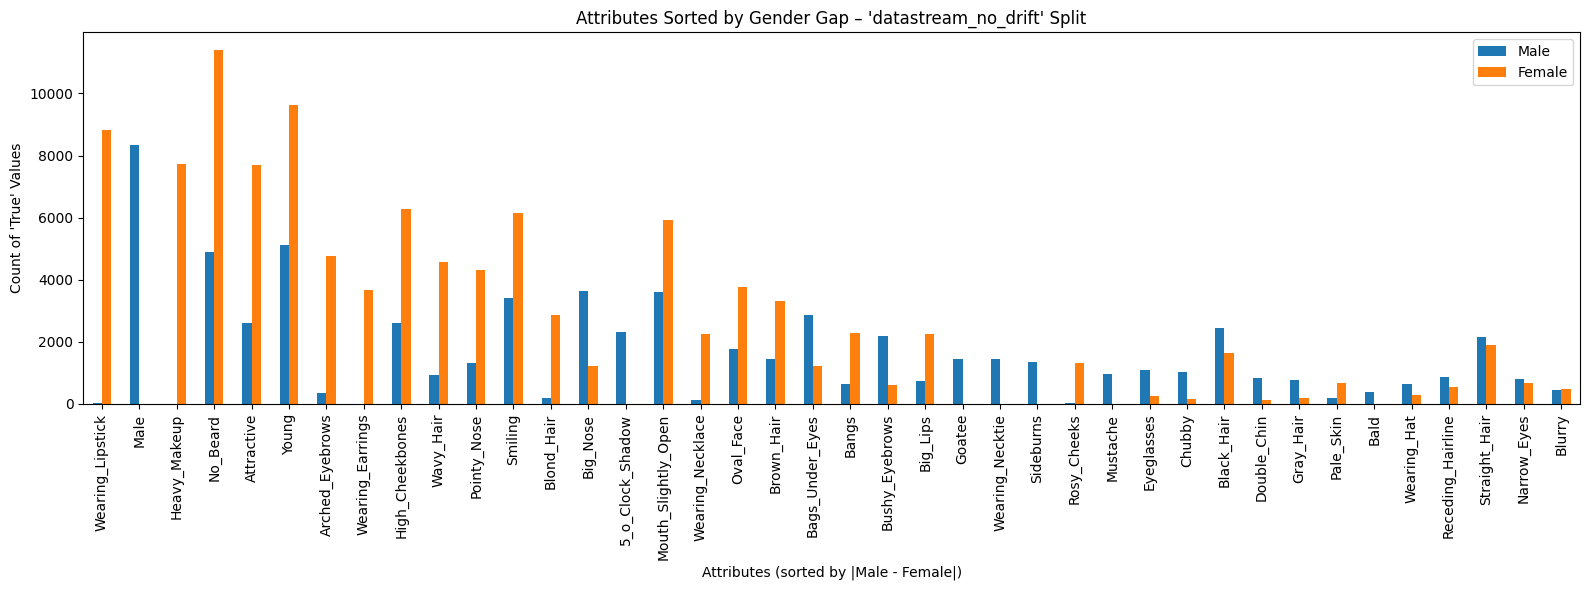

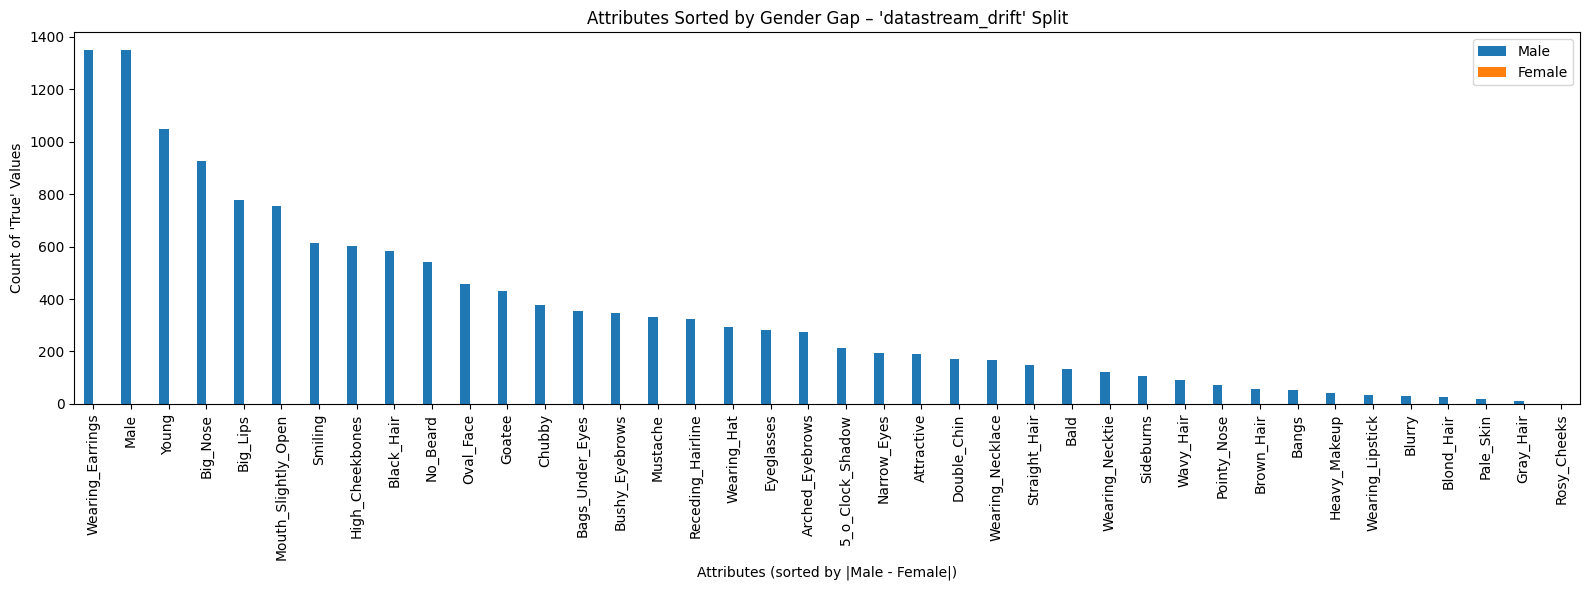

In [25]:
for split in ['historical_train', 'historical_test', 'datastream_no_drift', 'datastream_drift']:
    plot_sorted_counts(new_ds, split)

In [26]:
folder_path = "data/CelebA/"

os.makedirs(folder_path, exist_ok=True)

In [29]:
# Mapping for gender numbers to names
gender_map = {0: "Female", 1: "Male"}

# Convert drift_genders list to a string like "male", "female", or "male_female"
drifted_gender_names = [gender_map[g] for g in drift_genders]
drifted_gender_name = "_".join(sorted(set(drifted_gender_names)))  # sorted for consistent order

# For attributes: each tuple is (attribute_name, value)
# Convert to something like "Wearing_Earrings" or "not_Wearing_Earrings"
drift_attribute_descs = []
for attr, val in drift_attributes:
    if val == 1:
        drift_attribute_descs.append(attr)
    else:
        drift_attribute_descs.append(f"not_{attr}")
        
# Join attribute descriptions by underscore (or whatever separator you prefer)
drift_attribute_desc = "_".join(drift_attribute_descs)

# Final folder name
dataset_folder_name = f"CelebA_drift_simulated_with_{drifted_gender_name}_{drift_attribute_desc}"

print(dataset_folder_name)


CelebA_drift_simulated_with_male_Wearing_Earrings


In [30]:
new_ds.save_to_disk(f"{folder_path}/{dataset_folder_name}")

Saving the dataset (1/1 shards): 100%|██████████| 1349/1349 [00:00<00:00, 5196.21 examples/s]
